In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy

S0 = 100

## Cox-Ross-Rubinstein model

We consider a binomial model with $n\ge1$ periods with a non-risky asset $S^0$ with an interest rate of $r\ge0$, i.e its value at time $t$ is $S_t^0 = e^{rt}$, and a risky-asset $S$ evolving according to $S_{j+1} = S_k Z_{j+1}$, where $S_0>0$ and $(Z_j)_j$ is a sequence of i.i.d variables such that $\mathbb{P}(Z_j=u) = 1-\mathbb{P}(Z_j=d) = p$.

Here, we choose
$$u_n = e^{\mu h_n + \sigma \sqrt{h_n}}$$
$$d_n = e^{\mu h_n - \sigma \sqrt{h_n}}$$
with $\mu>0$, $\sigma>0$, $h_n=T/n$ for all $n\ge1$ with $T>0$ the maturity.

We denote $S_j^n$ the vector of size $j+1$ containing the values that can be taken by $S_j$, such that $(S_j^n)_i = S_0 u^{j-i} d^i$

In [2]:
def Sn(T: float, n: int, mu: float, sigma: float, j: int) -> np.ndarray:
    '''Returns the vector $S_j^n$'''

    # Assert variables are well-defined, for the next functions we will suppose it is the case
    assert T > 0
    assert n >= 1
    assert mu > 0
    assert sigma > 0
    assert 1 <= j <= n

    # Definition of h_n, u_n and d_n
    h = T / n
    u = np.exp(mu * h + sigma * np.sqrt(h))
    d = np.exp(mu * h - sigma * np.sqrt(h))

    # The vectors U and D contain respectively values from u^j to u^0
    # and d^0 to d^j
    U = np.power(u, np.arange(j, -1, -1))
    D = np.power(d, np.arange(0, j+1, 1))

    # S_j^n is S0 * U * D
    return S0 * U * D

For an European call option of maturity $T>0$ and of strike $K>0$, the payoff is $(S_T-K)^+$.

We denote $PO^n$ the vector of size $n+1$ containing the possibles values taken by the Payoff of an Euopean call option, such that $(PO^n)_i = [(S_n^n)_i - K]^+ = [S_0 u^{n-i} d^i - K]^+$

In [3]:
def Payoff(T: float, n: int, mu: float, sigma: float, K: float) -> np.ndarray:
    '''Returns the vector PO^n'''

    # S_n is at maturity so when j=n
    S_n = Sn(T, n, mu, sigma, n)
    
    return np.maximum(0, S_n - K)

### European call option price

The price of a call option at time $0$ under the no-arbitrage condition is

$$C^n = \frac{1}{S_n^0} \mathbb{E}^{\mathbb{Q}_n} [PO_n^n]$$

with $\mathbb{Q}^n$ defined such that $\mathbb{Q}^n(Z_j=u) = 1-\mathbb{Q}^n(Z_j=d) = q_n$ with
$$q_n=\frac{e^{rh_n}-d_n}{u_n-d_n}$$

So we have
$$ C^n = e^{-rT} \sum_{j=0}^n \binom{n}{j} (1-q_n)^j q_n^{n-j} (PO^n)_j$$

In [4]:
def Calln(T: float, n: int, r: float, mu: float, sigma: float, K: float) -> np.float64:
    '''Returns C^n'''

    # Definition of h_n, u_n, d_n and q_n
    h = T / n
    u = np.exp(mu * h + sigma * np.sqrt(h))
    d = np.exp(mu * h - sigma * np.sqrt(h))
    q = (np.exp(r * h) - d) / (u - d)

    # scipy.special.binom returns an array woth binomial coefficients
    binomial_distrib = (
        scipy.special.binom(n, np.arange(0, n+1)) 
        * np.power(1-q, np.arange(0, n+1, 1))
        * np.power(q, np.arange(n, -1, -1))
    )

    PO = Payoff(T, n, mu, sigma, K)

    # We compute expected value with dot product
    E_Qn_Payoffs = np.dot(binomial_distrib, PO)

    return np.exp(-r*T) * E_Qn_Payoffs

### Hedging strategy

The hedging strategy $\Delta_j^n$ at time $t_j^n=jh_n$ is a random variable. But it is $S_j$-measurable, i.e it is a function of $S_j$. So we can represent $\Delta_j^n$ as a vector of same size as $S_j^n$, such that $(\Delta_j^n)_i$ is the appropriate hedging strategy when $S_j=(S_j^n)_i$.

The chapter 2.3 gives the formula
$$\Delta_j^n(\omega) = \frac{B_{j+1}((\omega,u)) - B_{j+1}((\omega,d))}{u S_j^n(\omega) - d S_j^n(\omega)}$$
with the recursive definition
$$B_j(\omega) = e^{-rh_n} \cdot \mathbb{E}^{\mathbb{Q}_n}[B_{j+1}|S_j=S_j(\omega)]$$
and
$$B_n^n=PO^n$$

By the law of iterated expectations, for all $j$,
$$B_j(\omega)=e^{-(n-j)rh_n} \cdot \mathbb{E}^{\mathbb{Q}_n}[PO^n|S_j=S_j(\omega)]$$

Finally
$$\Delta_j^n(\omega) = \frac{e^{-(n-j)rh_n}}{u-d}\cdot \frac{1}{S_j^n(\omega)}\cdot
\Big(
    \mathbb{E}^{\mathbb{Q}_n}[(S_{j+1}Z_{j+2}...Z_n - K)^+|S_{j+1}=S_j^n(\omega)u_n]
    - \mathbb{E}^{\mathbb{Q}_n}[(S_{j+1}Z_{j+2}...Z_n - K)^+|S_{j+1}=S_j^n(\omega)d_n]
\Big)
$$

$$\Delta_j^n(S_j) = \frac{e^{-(n-j)rh_n}}{u-d}\cdot \frac{1}{S_j}\cdot
\Big(
    \mathbb{E}^{\mathbb{Q}_n}[(S_j u Z_{j+2}...Z_n - K)^+]
    - \mathbb{E}^{\mathbb{Q}_n}[(S_j d Z_{j+2}...Z_n - K)^+]
\Big)
$$

$$\Delta_j^n(S_j) = \frac{e^{-(n-j)rh_n}}{u-d}\cdot \frac{1}{S_j}\cdot
\sum_{k=0}^{n-j-1} \binom{n-j-1}{k} q_n^k (1-q_n)^{n-j-1-k}
\Big(\big(S_ju^{k+1}d^{n-j-1-k}-K\big)^+ - \big(S_ju^{k}d^{n-j-k}-K\big)^+\Big)
$$

In [5]:
def Deltan(T: float, n: int, r: float, mu: float, sigma: float, K: float, j: int) -> np.ndarray:
    '''Returns the \Delta_j^n vector'''

    # Definition of h_n, u_n, d_n and q_n
    h = T / n
    u = np.exp(mu * h + sigma * np.sqrt(h))
    d = np.exp(mu * h - sigma * np.sqrt(h))
    q = (np.exp(r * h) - d) / (u - d)

    S_j = Sn(T, n, mu, sigma, j)

    binomial_distrib = (
        scipy.special.binom(n-j-1, np.arange(0, n-j))
        * np.power(q, np.arange(0, n-j))
        * np.power(1-q, np.arange(n-j-1, -1, -1))
    )

    # We use a double_indexed matrix by both j and k
    V = np.sum(
        (np.maximum(0,
            np.outer(
                S_j,
                np.power(u, np.arange(1, n-j+1, 1)) * np.power(d, np.arange(n-j-1, -1, -1))
            ) - K) 
        - np.maximum(0,
            np.outer(
                S_j,
                np.power(u, np.arange(0, n-j, 1)) * np.power(d, np.arange(n-j, 0, -1))
            ) - K)
        ) * binomial_distrib,
        axis=1
    )
    
    return np.exp(-(n-j)*r*h) / (u-d) / S_j * V

### Dependence of Calln on $K$

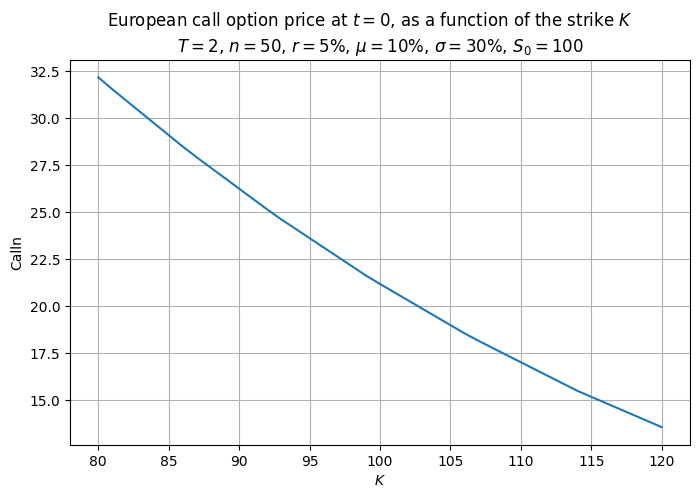

In [6]:
T, n, r, mu, sigma = 2, 150, .05, .1, .3

fig, ax = plt.subplots(figsize=(8, 5))

X = np.arange(80, 121, 1)
Y = np.array([Calln(T, n, r, mu, sigma, K) for K in X])

ax.plot(X, Y)
ax.grid(True)
ax.set_xlabel("$K$")
ax.set_ylabel("Calln")
plt.suptitle("European call option price at $t=0$, as a function of the strike $K$")
ax.set_title("$T=2$, $n=50$, $r=5\%$, $\mu=10\%$, $\sigma=30\%$, $S_0=100$")

plt.show()

We find that $K\mapsto C(T,K)$ is decreasing and convex, which is true in the general case.

### Dependence of Deltan on $K$

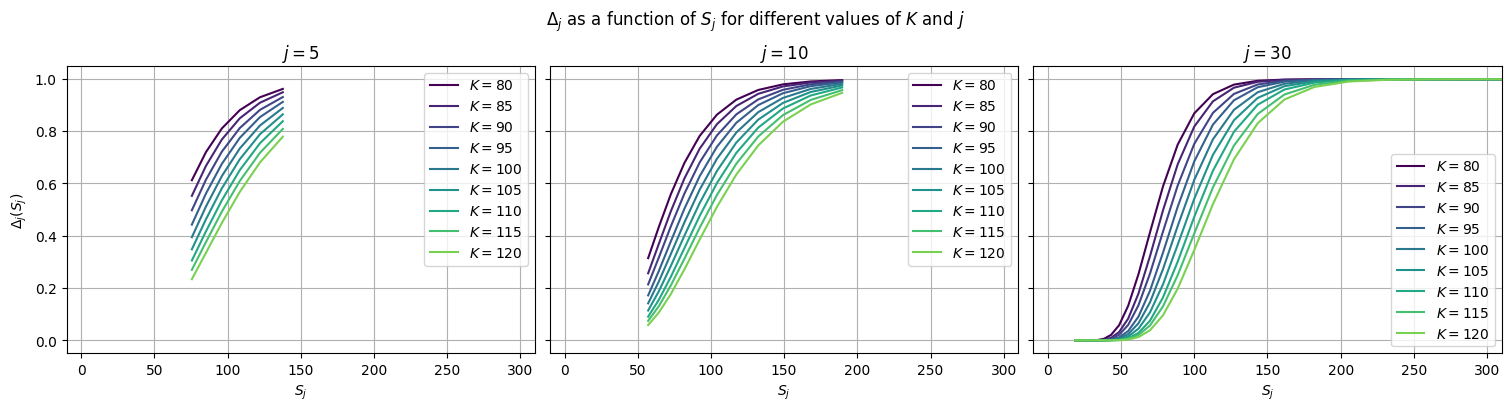

In [7]:
cmap=matplotlib.colormaps['viridis']
T, n, r, mu, sigma = 2, 50, .05, .1, .3

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True, layout='constrained', sharex=True)

for i, j in enumerate((5, 10, 30)):
    X = Sn(T, n, mu, sigma, j)
    for K in np.linspace(80, 120, 9):
        Y = Deltan(T, n, r, mu, sigma, K, j)
        axs[i].plot(X, Y, c=cmap((K-80)/50), label=f"$K=${K:.0f}")
    axs[i].set_title(f"$j=${j}")
    axs[i].grid(True)
    axs[i].legend()
    axs[i].set_xlabel("$S_j$")
    axs[i].set_xlim(-10,310)

axs[0].set_ylabel("$\Delta_j(S_j)$")
fig.suptitle("$\Delta_j$ as a function of $S_j$ for different values of $K$ and $j$")

plt.show()

## Black Scholes model

We then compare these results to the Black-Scholes formula. The **Proposition 9.1** gives the price of a European call option at $t=0$

$$
C = S_0 N (d_+) - \tilde K N (d_-)
$$
where
$$d_+ = \frac{ln(S_0/\tilde{K})}{\sigma\sqrt T} + \frac{\sigma \sqrt T}{2}
; \;
d_- = \frac{ln(S_0/\tilde{K})}{\sigma\sqrt T} - \frac{\sigma \sqrt T}{2}
; \;
\tilde K = K e^{-rT}
$$
and $N$ is the CDF of a standard normal distribution.

In [8]:
def Call(T: float, r: float, sigma: float, K: float) -> float:
    '''Returns C, under the Black-Scholes model'''

    Ktilde = K * np.exp(-r*T)
    v = sigma ** 2 * T
    
    dplus = np.log(S0/Ktilde) / np.sqrt(v) + np.sqrt(v) / 2
    dminus = np.log(S0/Ktilde) / np.sqrt(v) - np.sqrt(v) / 2

    price = S0 * scipy.stats.norm.cdf(dplus) - Ktilde * scipy.stats.norm.cdf(dminus)

    return price

In [9]:
def error(T: float, n:int, r: float, mu:float, sigma: float, K: float) -> float:
    '''Returns the relative error between the cost given by the CRR model and by the Black Scholes'''

    binomialModelPrice = Calln(T, n, r, mu, sigma, K)
    bsPrice = Call(T, r, sigma, K)
    return binomialModelPrice / bsPrice - 1

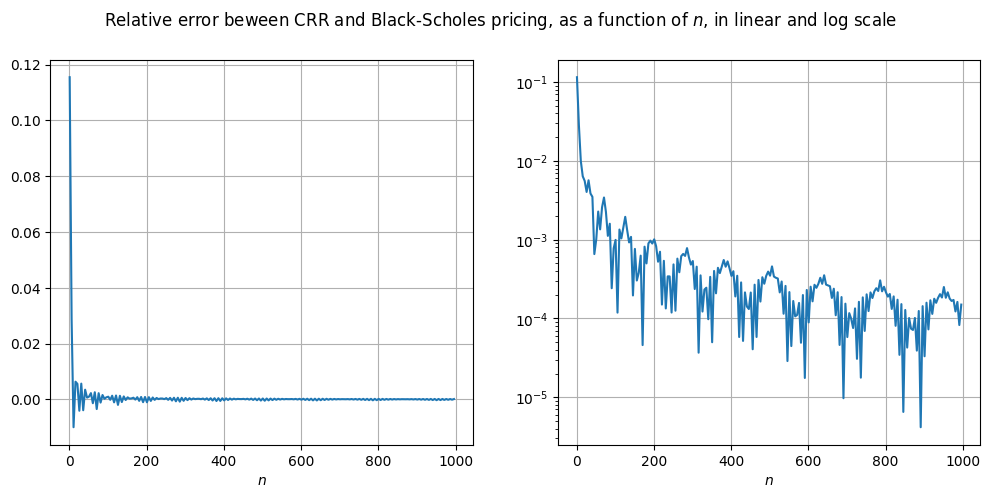

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

T, r, mu, sigma, K = 2, .05, .1, .3, 105

X = np.arange(1, 1000, 5)
Y = np.array([error(T, n, r, mu, sigma, K) for n in X])

ax1.plot(X, Y)
ax1.grid(True)
ax1.set_xlabel("$n$")

ax2.plot(X, abs(Y))
plt.yscale('log')
ax2.grid(True)
ax2.set_xlabel("$n$")

fig.suptitle("Relative error beween CRR and Black-Scholes pricing, as a function of $n$, in linear and log scale")

plt.show()